In [403]:
import torch
import numpy as np
import cv2 as cv
import random
import copy
import gymnasium as gym
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F

from tqdm import tqdm


from pettingzoo.classic import rps_v2
from pettingzoo.mpe import simple_v3

from stable_baselines3 import DQN

In [196]:
MAX_EPS = 30

In [427]:
env = simple_v3.env(render_mode="rgb_array")
env.reset(seed=42)

env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", render_mode="ansi", is_slippery=False)

env.reset()

In [428]:
ret = env.render()

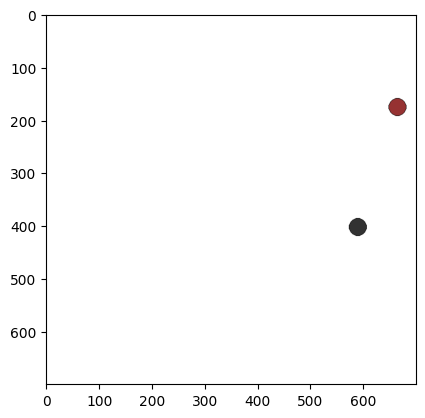

In [429]:
plt.imshow(ret)

In [562]:
def gen_int_map(ansi_map, dim=4):
    env_map = np.zeros((dim,dim), dtype=int)
    pos_int = {
        "S":0,
        "F":1,
        "H":2,
        "G":3
    }
    ct = 0
    for i in range(len(ret)):
        if ret[i] in pos_int.keys():
            env_map[ct//dim][ct%dim] = int(pos_int[ret[i]])
            ct+=1
    return env_map.flatten()

In [582]:
class Observer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv1 = nn.Conv2d(3,16, kernel_size=1)
        # self.bn1 = nn.BatchNorm2d(16)
        # self.conv2 = nn.Conv2d(16,3, kernel_size=1)
        # self.bn2 = nn.BatchNorm2d(3)
        # self.conv3 = nn.Conv2d(3,1, kernel_size=1)
        # self.bn3 = nn.BatchNorm2d(1)
        self.lin1 = nn.Linear(4, 64)
        self.lin2 = nn.Linear(64, 32)
        self.lin3 = nn.Linear(32 ,5)

    def forward(self, x):
        # x = self.conv1(x)
        # x = self.bn1(x)
        # x = self.conv2(x)
        # x = self.bn2(x)
        # x = self.conv3(x)
        # x = self.bn3(x)
        # x = nn.Flatten()(x)
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = self.lin3(x)
        x = F.tanh(x)
        return x

In [583]:
def conv_ohe_to_char(arr):
    arr = arr.detach().numpy()
    code_arr = np.ones(arr.shape[1])
    for j in range(len(code_arr)):
        code_arr[j] = 2**(code_arr.shape[0] - j-1)
    codes = []
    for i in arr:
        arr_i = (i > 0).astype(int)
        codes.append(chr(int(arr_i @ code_arr.T)))
    return codes

In [612]:
class Explorer(torch.nn.Module):
    def __init__(self, n_actions=4):
        super().__init__()
        self.lin1 = nn.Linear(n_actions**2, 32)
        self.lin2 = nn.Linear(32, 64)
        
        # self.conv1 = nn.Conv2d(1,3, 1)
        # self.bn1 = nn.BatchNorm2d(3)
        # self.conv2 = nn.Conv2d(3,3, 1)
        # self.bn2 = nn.BatchNorm2d(3)
        # self.conv3 = nn.Conv2d(3,1, 1)
        # self.bn3 = nn.BatchNorm2d(1)
        
        self.lin3 = nn.Linear(64, 16)
        self.lin4 = nn.Linear(16, n_actions)

    def forward(self, x):
        x = self.lin1(x)
        x = self.lin2(x)

        x = x.reshape(-1, 1, int(x.shape[1]**0.5), int(x.shape[1]**0.5))
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = nn.Flatten()(x)

        x = self.lin3(x)
        x = F.relu(x)
        x = self.lin4(x)

        x = F.softmax(x, dim=1)
        return x

In [613]:
def get_rew(lake_map, prev_pos, new_pos, n_dim=4):
    goal_pos = np.array([np.where(lake_map == 3)[0][0], np.where(lake_map == 3)[1][0]])
    prev_pos_cord = np.array([prev_pos // n_dim, prev_pos % n_dim])
    new_pos_cord = np.array([new_pos // n_dim, new_pos % n_dim])
    reward = np.sum(np.abs((prev_pos_cord - goal_pos) - (new_pos_cord - goal_pos)))
    return reward

In [614]:
model1 = Observer()
model1_ref = Observer()
model2 = Explorer(4)

optimizer1 = torch.optim.SGD(model1.parameters(), lr=1e-1)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=1e-3)

In [615]:
model1

Observer(
  (lin1): Linear(in_features=4, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=5, bias=True)
)

In [616]:
rewards_train = []
memory = []
exp_rate = 0.99
exp_rates_ = []

for i in tqdm(range(500)):
    curr_state = env.reset()
    curr_state, _, _, _, _ = env.last()
    ep_done = False
    ep_count = 0

    s_mem = []
    a_mem = []
    r_mem = []
    n_s_mem = []
    log_probs = []

    
    for agent in env.agent_iter():
        curr_state, reward, termination, truncation, info = env.last()
        if termination or truncation:
            break
        ret = env.render()
        # inp_map = torch.tensor(gen_int_map(ret).reshape(1,1,-1).astype('float32'))/
        # inp_model = torch.FloatTensor(F.one_hot(torch.LongTensor([curr_state]), num_classes=16).detach().numpy())
        inp_model = torch.Tensor(np.array([ret]))
        # print(inp_model.shape)
        inp_model = inp_model.swapaxes(3,1)
        inp_model = inp_model.swapaxes(2,3)
        # print(inp_model.shape)
        # print(curr_state)
        op1 = model1(torch.Tensor(np.array([curr_state])))
        if random.random() < exp_rate:
            action_ = env.action_space(agent).sample()
        else:
            action_ = torch.argmax(op1).detach().numpy()

        env.step(action_)
        new_state, reward, failed, done, info= env.last()

        memory.append([curr_state, action_, reward, new_state])
        
        s_mem.append(curr_state)
        a_mem.append(action_)
        r_mem.append(reward)
        if failed or done:
            n_s_mem.append(None)
        else:
            n_s_mem.append(new_state)


        if done or failed:
            ep_done = True

        if len(memory) < 128:
            continue
        random_batch = random.sample(memory, 128)
        for mem_i in random_batch:
            s_i, a_i, r_i, s_i1 = mem_i
            if s_i1 is None:
                yj = r_i
            else:
                yj = r_i + 0.9 * torch.max(model1_ref(torch.Tensor(np.array([s_i1]))))
            loss = torch.pow(yj - model1(torch.Tensor(np.array([s_i])))[0][a_i], 2)
            # print("Loss - ", loss)
            optimizer1.zero_grad()
            loss.backward()
            optimizer1.step()

    
    rewards_train.append(np.sum(r_mem[-1]))

   
    if i % 50 == 0:
        model1_ref = model1
    # for t in range(len(r_mem)):
    #     G = 0.0
    #     for k, r in enumerate(r_mem[t:]):
    #         G += r
    #     g.append(G)

    # for State, Action, G in zip(s_mem, a_mem, g):
    #     probs = model1(torch.Tensor(np.array([State])))
    #     dist = torch.distributions.Categorical(probs=probs)
    #     log_prob = dist.log_prob(torch.LongTensor([Action]))
        
    #     loss = - log_prob*G
        
        
    #     optimizer1.zero_grad()
    #     loss.sum().backward()
    #     optimizer1.step()
    exp_rate *= 0.99

    exp_rates_.append(exp_rate)

100%|█████████████████████████████████████████| 500/500 [04:58<00:00,  1.68it/s]


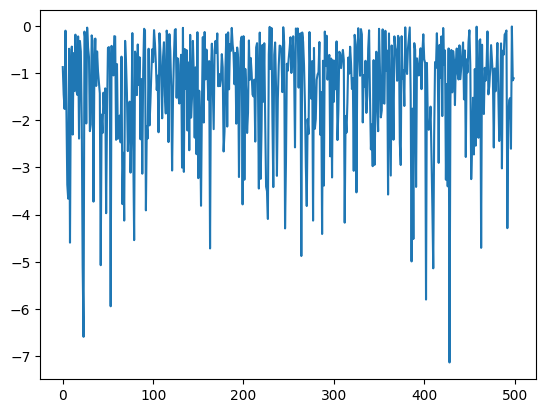

In [617]:
plt.plot(rewards_train)

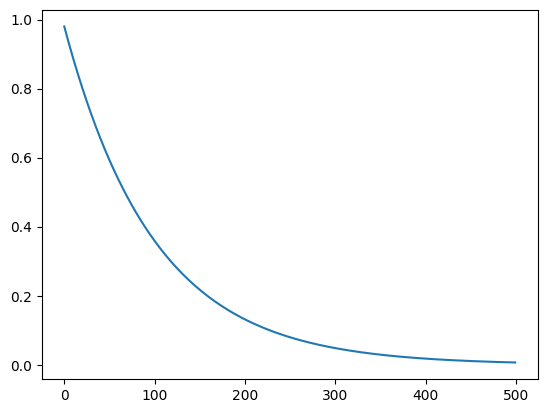

In [618]:
plt.plot(exp_rates_)

False
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000]], grad_fn=<TanhBackward0>)
0
REWARD =  -0.02785050109452548
False
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000]], grad_fn=<TanhBackward0>)
0
REWARD =  -0.02785050109452548
False
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000]], grad_fn=<TanhBackward0>)
0
REWARD =  -0.02785050109452548
False
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000]], grad_fn=<TanhBackward0>)
0
REWARD =  -0.02785050109452548
False
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000]], grad_fn=<TanhBackward0>)
0
REWARD =  -0.02785050109452548
False
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000]], grad_fn=<TanhBackward0>)
0
REWARD =  -0.02785050109452548
False
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000]], grad_fn=<TanhBackward0>)
0
REWARD =  -0.02785050109452548
False
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000]], grad_fn=<TanhBackward0>)
0
REWARD =  -0.02785050109452548
False
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000]], grad_fn=<TanhBackward0>

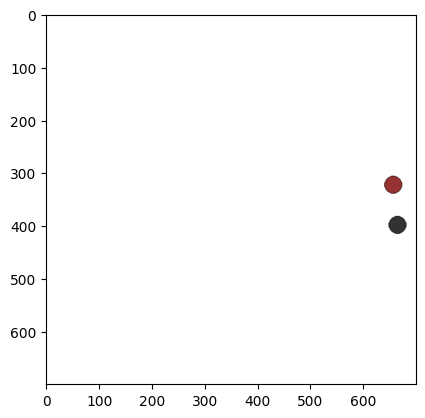

In [619]:
env.reset()
ep_done = False
rews_test = []
actions_ = []
while not ep_done:
    print(ep_done)
    ret = env.render()
    plt.imshow(ret)
    # plt.show()
    ret, _,_,_,_ = env.last()
    op1 = model1_ref(torch.Tensor(np.array([ret])))
    print(op1)
    action_ = torch.argmax(op1).item()
    print(action_)
    actions_.append(action_)
    env.step(action_)
    new_state, reward, failed, done, info= env.last(action_)
    print("REWARD = ", reward)
    curr_state = new_state
    if done or failed:
        ep_done = True
    rews_test.append(reward)

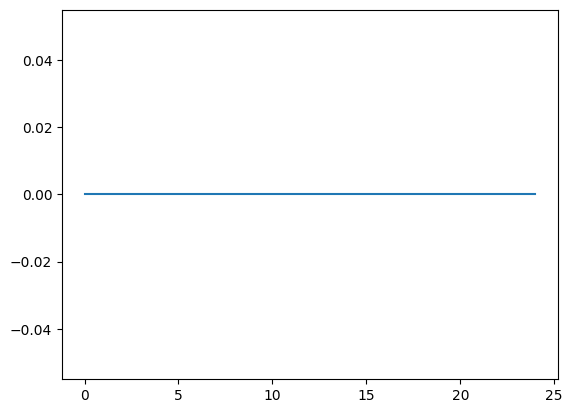

In [620]:
plt.plot(actions_)

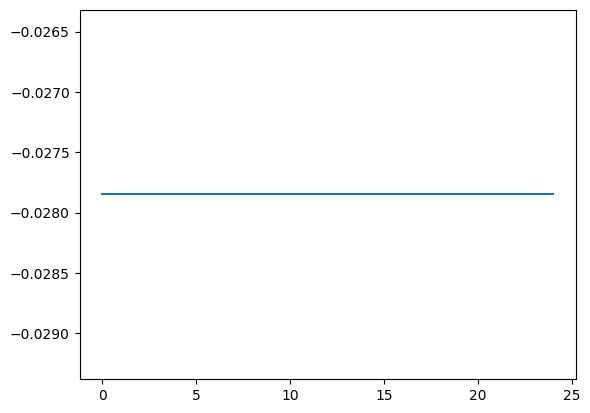

In [621]:
plt.plot(rews_test)

In [176]:
rewards_train = []
for i in tqdm(range(1000)):
    env.reset()
    ep_done = False
    rew_i = []
    action_i = []
    state_i = []
    while not ep_done:
        ret = env.render()
        inp_map = torch.tensor(gen_int_map(ret).reshape(1,1,4,4).astype('float32'))
        op1 = torch.distributions.Categorical(model1(inp_map))
        
        action_ = op1.sample()

        new_state, reward, failed, done, info= env.step(action_.item())
        print(env.observation_space)
        break
        if reward > 0:
            print("REACHED GOAL")
            reward = 10
            ep_done = True
        elif done or failed:
            reward = -10
            ep_done = True
        else:
            reward = 0.1
        
        action_i.append(action_)
        state_i.append(gen_int_map(ret))
        rew_i.append(reward)

        optimizer1.zero_grad()
        loss_i = -1 * op1.log_prob(action_) * reward
        loss_i.backward()
        optimizer1.step()
    rewards_train.append(rew_i)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

tensor([[[[0., 1., 1., 1.],
          [1., 2., 1., 2.],
          [1., 1., 1., 2.],
          [2., 1., 1., 3.]]]])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x4 and 16x32)

In [668]:
rewards_mean = [np.mean(i) for i in rewards_train]

In [669]:
rewards_train[0]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [670]:
rewards_mean[0]

0.0004714950493019823

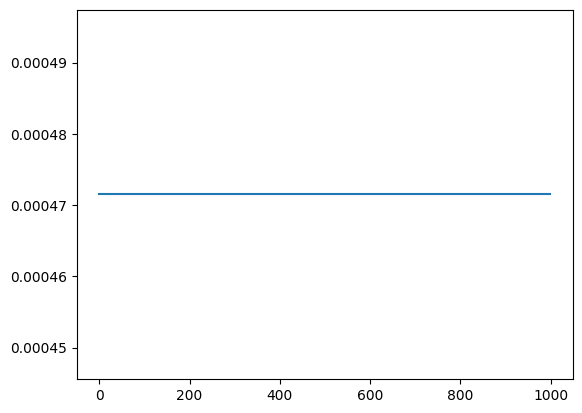

In [671]:
plt.plot(rewards_mean)

In [672]:
rewards_train[-1]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

## Initialization

In [39]:
model1 = Observer()
model2 = Explorer(4)

optimizer1 = torch.optim.SGD(model1.parameters(), lr=1e-6)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=1e-6)

## Metrics before train

In [13]:
rews_pretrain = []

In [14]:
with torch.no_grad():
    for i in range(10):
        rews_i = []
        stop_ep = False
        env.reset()
        while not stop_ep:
            ret = env.render()
            inp_map = torch.tensor(gen_int_map(ret).reshape(1,1,4,4).astype('float32'))
            op1 = model1(inp_map)
            op2 = model2(op1.detach())
            
        
            action_i = torch.argmax(op2).item()
            # action_i = env.action_space.sample()
            new_state, reward, failed, done, info= env.step(action_i)
            if done or failed:
                if failed:
                    reward = -1
                else:
                    reward = 10
                stop_ep = True
            else:
                reward+=1
            rews_i.append(reward)
        rews_pretrain.append(rews_i)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x4 and 10x32)

In [15]:
rews_mean = []
for i in range(len(rews_pretrain)):
    rews_mean.append(np.mean(rews_pretrain[i]))

In [98]:
np.mean(rews_mean)

0.4583333333333333

## Train

In [110]:
rewards_train = []
for i in tqdm(range(1)):
    env.reset()
    ep_done = False
    rew_i = []
    while not ep_done:
        ret = env.render()
        inp_map = torch.tensor(gen_int_map(ret).reshape(1,1,4,4).astype('float32'))
        op1 = model1(inp_map)
        print(op1.shape)
        op2 = model2(op1.detach())
        print(op2.shape)
        
    
        action_i = torch.argmax(op2).item()
        action_back = torch.zeros_like(op1[0])

        new_state, reward, failed, done, info= env.step(action_i)
        if done or failed:
            reward = -1
            ep_done = True
        else:
            reward+=1
        rew_i.append(reward)
        
        action_back[action_i] = reward
        
        loss_1 = torch.mul(op1, -reward)
        loss_2 = op1 * action_back

        print(loss_2)
        
    
        optimizer_1.zero_grad()
        optimizer_2.zero_grad()
        loss_1.sum().backward()
        
        
        break
        loss_2.sum().backward()
        optimizer_1.step()
        optimizer_2.step()
    rewards_train.append(rew_i)

  0%|                                                     | 0/1 [00:00<?, ?it/s]

torch.Size([1, 10])
torch.Size([1, 4])
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<CeilBackward0>)


NameError: name 'optimizer_1' is not defined

In [111]:
rew_mean_train = []
for i in range(len(rewards_train)):
    rew_mean_train.append(np.mean(rewards_train[i]))

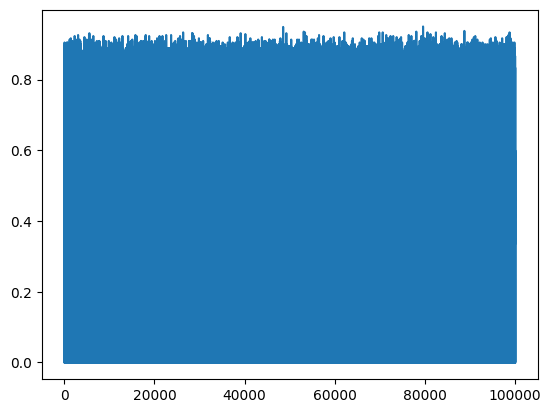

In [111]:
plt.plot(rew_mean_train)

In [112]:
rew_mean_train

[0.3333333333333333,
 0.3333333333333333,
 0.5,
 0.3333333333333333,
 0.8461538461538461,
 0.5,
 0.6,
 0.5,
 0.3333333333333333,
 0.5,
 0.6,
 0.8947368421052632,
 0.0,
 0.6,
 0.5,
 0.6,
 0.7142857142857143,
 0.8181818181818182,
 0.6,
 0.3333333333333333,
 0.5,
 0.5,
 0.6666666666666666,
 0.3333333333333333,
 0.0,
 0.0,
 0.5,
 0.7777777777777778,
 0.875,
 0.75,
 0.6,
 0.6666666666666666,
 0.6,
 0.0,
 0.8,
 0.5,
 0.8571428571428571,
 0.6,
 0.5,
 0.5,
 0.7142857142857143,
 0.3333333333333333,
 0.5,
 0.6666666666666666,
 0.3333333333333333,
 0.3333333333333333,
 0.0,
 0.8461538461538461,
 0.0,
 0.0,
 0.9,
 0.8181818181818182,
 0.3333333333333333,
 0.0,
 0.8666666666666667,
 0.75,
 0.6,
 0.0,
 0.3333333333333333,
 0.7142857142857143,
 0.0,
 0.6666666666666666,
 0.0,
 0.3333333333333333,
 0.9047619047619048,
 0.3333333333333333,
 0.0,
 0.5,
 0.3333333333333333,
 0.6666666666666666,
 0.7777777777777778,
 0.6,
 0.5,
 0.0,
 0.7142857142857143,
 0.6,
 0.5,
 0.7777777777777778,
 0.6,
 0.333333333

In [118]:
np.mean(rew_mean_train[-10:])

0.3992063492063492

## Metrics post training

In [103]:
rews_test = []

In [104]:
with torch.no_grad():
    for i in range(10):
        rews_i = []
        stop_ep = False
        env.reset()
        while not stop_ep:
            ret = env.render()
            inp_map = torch.tensor(gen_int_map(ret).reshape(1,1,4,4).astype('float32'))
            op1 = model1(inp_map)
            op2 = model2(op1.detach())
            
        
            action_i = torch.argmax(op2).item()
            # action_i = env.action_space.sample()
            new_state, reward, failed, done, info= env.step(action_i)
            if done or failed:
                if failed:
                    reward = -1
                else:
                    reward = 10
                stop_ep = True
            else:
                reward+=1
            rews_i.append(reward)
        rews_test.append(rews_i)

In [105]:
rews_mean_test = []
for i in range(len(rews_test)):
    rews_mean_test.append(np.mean(rews_test[i]))

In [106]:
np.mean(rews_mean_test)

0.5036363636363637

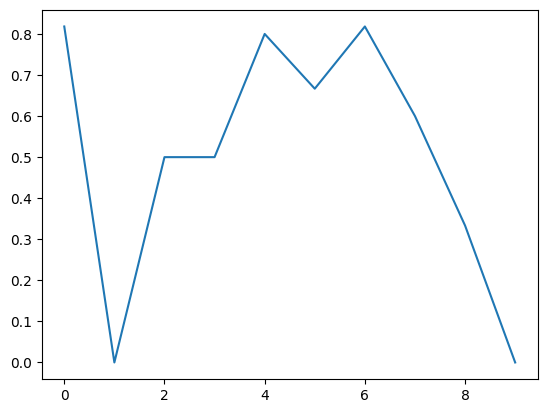

In [108]:
plt.plot(rews_mean_test)

In [64]:
env.reset()
with torch.no_grad():
    for i in range(100):
        ret = env.render()
        inp_map = torch.tensor(gen_int_map(ret).reshape(1,1,4,4).astype('float32'))
        op1 = model1(inp_map)
        op2 = model2(op1.detach())
        
    
        action_i = torch.argmax(op2).item()
        # action_i = env.action_space.sample()
        new_state, reward, failed, done, info= env.step(action_i)
        if done or failed:
            reward = -1
            break
        else:
            reward+=1
        
        loss_1 = torch.mul(op1, -reward)
        loss_2 = torch.mul(op2, -reward)

        print(reward)

1.0
1.0
1.0
